<a href="https://colab.research.google.com/github/John-gram/DataAnalyticsProject/blob/main/John_Ezembu's_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# CELL1: Install Dependencies
!pip install medmnist seaborn matplotlib scikit-learn pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 101.4 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha25

In [ ]:
# CELL 2: Import Libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import medmnist
from medmnist import INFO
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F

100%|██████████| 3.29M/3.29M [00:02<00:00, 1.23MB/s]

EHR Data Sample:


,HbA1c,diabetes_duration,age
0,7.748357,11,60.791780
1,7.430868,5,58.482722
2,7.823844,15,43.180571
3,10.261515,5,63.354943
4,8.882923,12,43.018160


EHR Data Sample:


,HbA1c,diabetes_duration,age
0,8.748357,3,68.885823
1,7.930868,1,28.406486
2,7.823844,16,34.216233
3,8.261515,6,42.593599
4,7.382923,17,43.224716


EHR Data Sample:


,HbA1c,diabetes_duration,age
0,7.748357,11,60.791780
1,7.430868,5,58.482722
2,7.823844,15,43.180571
3,10.261515,5,63.354943
4,8.882923,12,43.018160


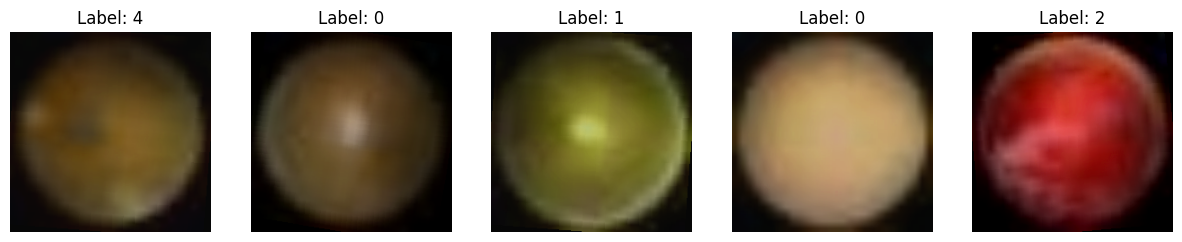

In [ ]:
# CELL 3: Load and Visualize Dataset
data_flag = 'retinamnist'
download = True
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])
train_dataset = DataClass(split='train', download=download)
test_dataset = DataClass(split='test', download=download)

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class MultimodalDataset(Dataset):
    def __init__(self, image_dataset, num_samples, transform=None):
        self.images = image_dataset.imgs
        self.labels = image_dataset.labels
        self.num_samples = num_samples
        self.transform = transform
        np.random.seed(42)
        self.ehr_data = pd.DataFrame({
            'HbA1c': np.random.normal(loc=7.5 + 0.5 * self.labels.flatten(), scale=0.5),
            'diabetes_duration': np.random.randint(1, 20, size=len(self.labels)),
            'age': np.random.normal(55, 10, len(self.labels))
        })
        print("EHR Data Sample:")
        display(self.ehr_data.head())

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        img_idx = idx % len(self.images)
        image = Image.fromarray(self.images[img_idx])
        if self.transform:
            image = self.transform(image)
        label = self.labels[img_idx][0]
        ehr = torch.tensor(self.ehr_data.iloc[img_idx].values, dtype=torch.float32)
        return image, ehr, label

train_multimodal_full = MultimodalDataset(train_dataset, num_samples=len(train_dataset), transform=train_transform)
test_multimodal = MultimodalDataset(test_dataset, num_samples=len(test_dataset), transform=test_transform)

train_indices = list(range(len(train_multimodal_full)))
val_size = int(0.2 * len(train_indices))
train_indices, val_indices = train_test_split(train_indices, test_size=val_size, random_state=42)

train_multimodal = Subset(train_multimodal_full, train_indices)
val_multimodal_dataset = MultimodalDataset(train_dataset, num_samples=len(train_dataset), transform=test_transform)
val_multimodal = Subset(val_multimodal_dataset, val_indices)

train_loader = DataLoader(train_multimodal, batch_size=16, shuffle=True)
val_loader = DataLoader(val_multimodal, batch_size=16, shuffle=False)
test_loader = DataLoader(test_multimodal, batch_size=16, shuffle=False)

def visualize_images(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        image, _, label = dataset[i]
        image = image.permute(1, 2, 0)
        image = image * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
        image = image.clamp(0, 1)
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')
    plt.show()

visualize_images(train_multimodal)


In [ ]:
# CELL 4: Define the Fusion Model
class FusionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.image_encoder = nn.Sequential(
            *list(torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True).children())[:-1]
        )
        self.image_proj = nn.Linear(512, 256)
        self.ehr_encoder = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 256)
        )
        self.attention = nn.MultiheadAttention(embed_dim=256, num_heads=8)
        self.classifier = nn.Linear(256, 5)

    def forward(self, img, ehr):
        img_feat = self.image_encoder(img).view(img.size(0), 512)
        img_feat = self.image_proj(img_feat)
        ehr_feat = self.ehr_encoder(ehr)
        fused = torch.stack([img_feat, ehr_feat], dim=1)
        attn_output, _ = self.attention(fused, fused, fused)
        fused_feat = attn_output.mean(dim=1)
        return self.classifier(fused_feat)

model = FusionModel()


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 163MB/s]


In [ ]:
# CELL 5: Train and Evaluate the Model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Compute class weights for imbalanced dataset
labels = [label for _, _, label in train_multimodal]
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True)

def compute_auroc(model, loader, device):
    model.eval()
    true_labels = []
    pred_probs = []
    with torch.no_grad():
        for img, ehr, label in loader:
            img, ehr, label = img.to(device), ehr.to(device), label.to(device)
            outputs = model(img, ehr)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            pred_probs.extend(probs)
            true_labels.extend(label.cpu().numpy())
    true_labels = np.array(true_labels)
    pred_probs = np.array(pred_probs)
    auroc = roc_auc_score(true_labels, pred_probs, multi_class='ovr')
    return auroc

num_epochs = 150
patience = 15
best_auroc = 0
patience_counter = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for img, ehr, label in train_loader:
        img, ehr, label = img.to(device), ehr.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = model(img, ehr)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for img, ehr, label in val_loader:
            img, ehr, label = img.to(device), ehr.to(device), label.to(device)
            outputs = model(img, ehr)
            loss = criterion(outputs, label)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_auroc = compute_auroc(model, val_loader, device)
    print(f"Validation Loss: {val_loss:.4f}, Validation AUROC: {val_auroc:.4f}")

    scheduler.step(val_loss)

    if val_auroc > best_auroc:
        best_auroc = val_auroc
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            break

model.load_state_dict(torch.load('best_model.pth'))

model.eval()
true_labels = []
pred_probs = []
with torch.no_grad():
    for img, ehr, label in test_loader:
        img, ehr, label = img.to(device), ehr.to(device), label.to(device)
        outputs = model(img, ehr)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        pred_probs.extend(probs)
        true_labels.extend(label.cpu().numpy())
true_labels = np.array(true_labels)
pred_probs = np.array(pred_probs)

auroc = roc_auc_score(true_labels, pred_probs, multi_class='ovr')
f1 = f1_score(true_labels, np.argmax(pred_probs, axis=1), average='macro')
precision = precision_score(true_labels, np.argmax(pred_probs, axis=1), average='macro')
recall = recall_score(true_labels, np.argmax(pred_probs, axis=1), average='macro')
print(f"AUROC: {auroc:.3f}, F1-Score: {f1:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")

cm = confusion_matrix(true_labels, np.argmax(pred_probs, axis=1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1, Train Loss: 1.2864
Validation Loss: 1.3945, Validation AUROC: 0.7410
Epoch 2, Train Loss: 1.2307
Validation Loss: 1.3998, Validation AUROC: 0.7528
Epoch 3, Train Loss: 1.1499
Validation Loss: 1.5047, Validation AUROC: 0.7607
Epoch 4, Train Loss: 1.1299
Validation Loss: 1.5512, Validation AUROC: 0.7334
Epoch 5, Train Loss: 1.1816
Validation Loss: 1.3843, Validation AUROC: 0.7468
Epoch 6, Train Loss: 1.1187
Validation Loss: 1.4147, Validation AUROC: 0.7438
Epoch 7, Train Loss: 1.0740
Validation Loss: 1.5859, Validation AUROC: 0.7281
Epoch 8, Train Loss: 1.0499
Validation Loss: 1.4514, Validation AUROC: 0.7571
Epoch 9, Train Loss: 0.9782
Validation Loss: 1.6886, Validation AUROC: 0.7367
Epoch 10, Train Loss: 1.0342
Validation Loss: 1.7458, Validation AUROC: 0.7168
Epoch 11, Train Loss: 0.9711
Validation Loss: 1.8621, Validation AUROC: 0.6904
Epoch 12, Train Loss: 0.8532
Validation Loss: 1.5414, Validation AUROC: 0.7333
Epoch 13, Train Loss: 0.8089
Validation Loss: 1.6392, Validat

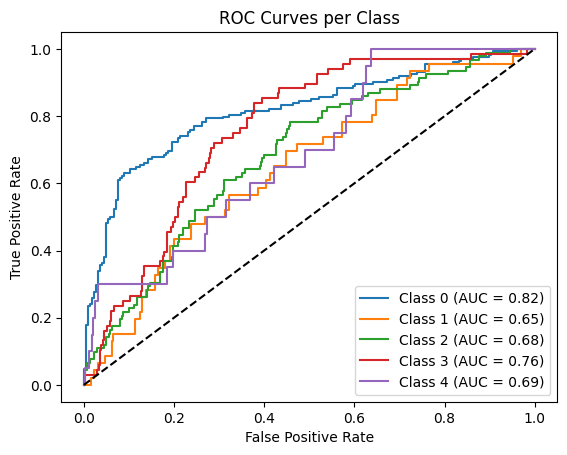

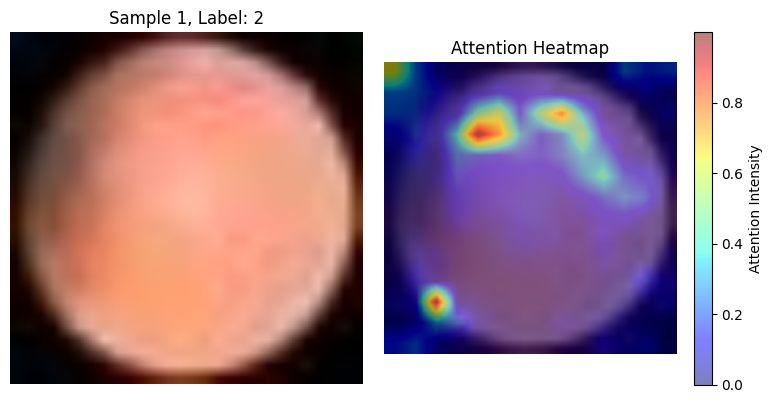

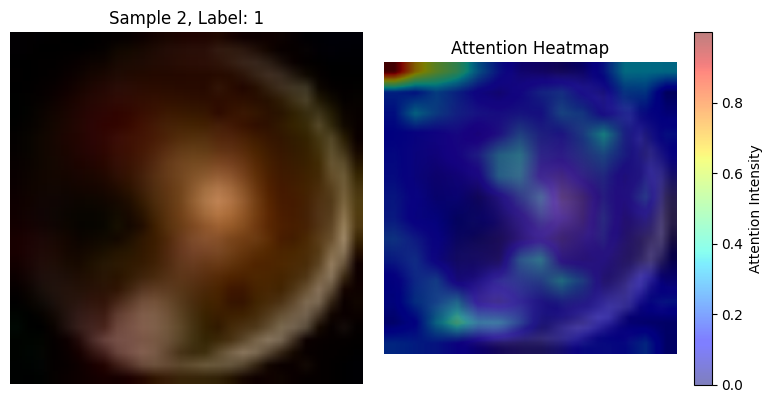

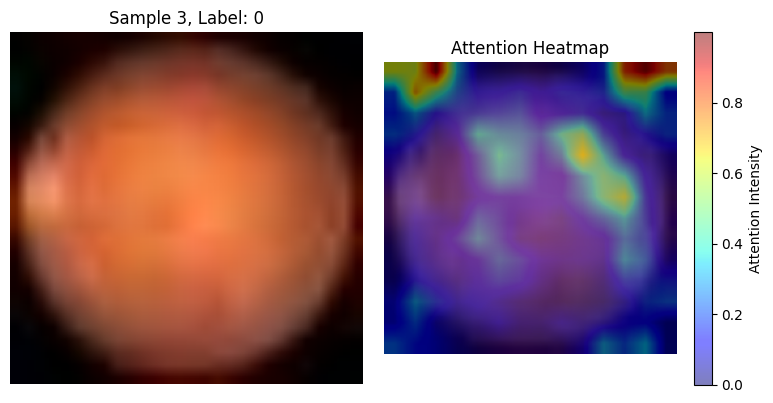

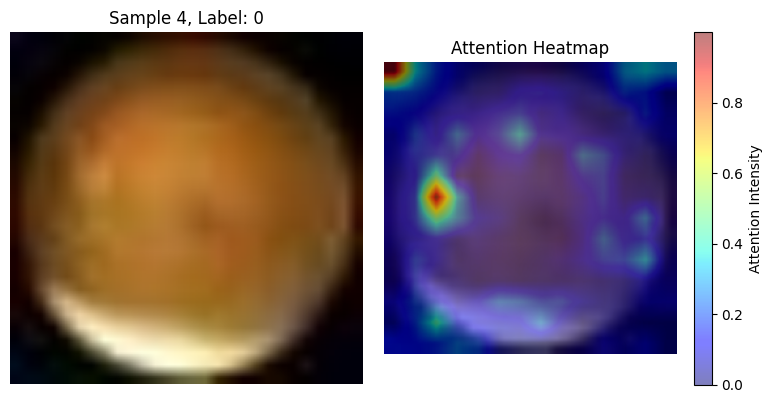

In [ ]:
# CELL 6:Plot ROC Curves and Spatial Attention Heatmaps
# Plot ROC Curves
y_true_bin = label_binarize(true_labels, classes=[0, 1, 2, 3, 4])
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(5):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(5):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves per Class')
plt.legend()
plt.show()

# Define denormalize function for images
def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img * std + mean

# Register hook to capture layer3 output (14x14 spatial feature map)
feature_map = None
def hook_fn(module, input, output):
    global feature_map
    feature_map = output

hook_handle = model.image_encoder[6].register_forward_hook(hook_fn)

# Get a batch from test_loader
batch = next(iter(test_loader))
img, ehr, label = batch
img, ehr = img.to(device), ehr.to(device)

# Run model to capture feature_map
model.eval()
with torch.no_grad():
    _ = model(img, ehr)

# Compute EHR features
ehr_feat = model.ehr_encoder(ehr)  # Shape: (batch_size, 256)

# Compute spatial attention
batch_size = img.size(0)
spatial_feats = feature_map.view(batch_size, 256, -1).permute(0, 2, 1)  # Shape: (batch_size, 196, 256)
query = ehr_feat.unsqueeze(1)  # Breakfast_size, 1, 256)
scores = torch.bmm(query, spatial_feats.transpose(1, 2)) / (256 ** 0.5)  # Shape: (batch_size, 1, 196)
attn_weights = torch.softmax(scores, dim=-1).squeeze(1)  # Shape: (batch_size, 196)
attn_map = attn_weights.view(batch_size, 14, 14)  # Shape: (batch_size, 14, 14)

# Visualize heatmaps for the first 4 samples
num_samples = 4
for i in range(min(num_samples, batch_size)):
    # Denormalize image
    img_denorm = denormalize(img[i].cpu()).clamp(0, 1).permute(1, 2, 0).numpy()

    # Upsample attention map to 224x224
    attn_up = F.interpolate(
        attn_map[i].unsqueeze(0).unsqueeze(0),
        size=(224, 224),
        mode='bilinear',
        align_corners=False
    ).squeeze().detach().cpu().numpy()

    # Normalize attention map for visualization
    attn_up = (attn_up - attn_up.min()) / (attn_up.max() - attn_up.min() + 1e-8)

    # Plot original image and heatmap
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img_denorm)
    plt.title(f"Sample {i+1}, Label: {label[i].item()}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img_denorm)
    plt.imshow(attn_up, alpha=0.5, cmap='jet')
    plt.colorbar(label='Attention Intensity')
    plt.title("Attention Heatmap")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Clean up
hook_handle.remove()


In [ ]:
# CELL 7: Federated Learning with FedML and Additional Visualizations
# Step 1: Uninstall existing NumPy and reinstall a compatible version
!pip uninstall -y numpy
!pip install numpy==1.26.4

# Step 2: Install a specific version of setuptools to avoid conflicts
!pip install setuptools==60.8.2

# Step 3: Install FedML with a version known to work with NumPy 1.26.4
!pip install fedml==0.7.0

# Step 4: Verify NumPy version after installation
import numpy as np
print(f"NumPy version: {np.__version__}")
assert np.__version__ == '1.26.4', "NumPy version mismatch - please restart runtime and rerun this cell"

# Import FedML and its components
import fedml
from fedml import FedMLRunner
from fedml.data import FedData
from fedml.trainer import FedMLTrainer

# Define device (utilizing T4 GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Reuse model and data loaders (assumes FusionModel, train_multimodal, test_multimodal defined in prior cells)
model = FusionModel().to(device)  # Fresh model instance for federated learning
train_loader = DataLoader(train_multimodal, batch_size=16, shuffle=True)
test_loader = DataLoader(test_multimodal, batch_size=16, shuffle=False)

# Simulate 2 clients by splitting the training data
num_clients = 2
train_data = [train_multimodal[i::num_clients] for i in range(num_clients)]
fed_data = FedData(train_data)

# Define a custom trainer for FedML with performance tracking
class CustomTrainer(FedMLTrainer):
    def __init__(self, model, device):
        super().__init__()
        self.model = model
        self.device = device
        self.criterion = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=5e-5)
        self.client_losses = []  # Track losses per training round
        self.client_accuracies = []  # Track accuracies per training round

    def train(self, data, device, args):
        img, ehr, label = data
        img, ehr, label = img.to(device), ehr.to(device), label.to(device)
        self.optimizer.zero_grad()
        outputs = self.model(img, ehr)
        loss = self.criterion(outputs, label)
        loss.backward()
        self.optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == label).sum().item() / label.size(0)
        self.client_losses.append(loss.item())
        self.client_accuracies.append(accuracy)
        return loss.item()

    def get_model_params(self):
        return self.model.cpu().state_dict()

    def set_model_params(self, model_parameters):
        self.model.load_state_dict(model_parameters)

    def evaluate(self, data, device, args):
        img, ehr, label = data
        img, ehr, label = img.to(device), ehr.to(device), label.to(device)
        self.model.eval()
        with torch.no_grad():
            outputs = self.model(img, ehr)
            loss = self.criterion(outputs, label).item()
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == label).sum().item()
            total = label.size(0)
        return loss, total, {"accuracy": correct / total}

# Initialize and run FedML simulation
fedml_runner = FedMLRunner(
    args=fedml.init(),
    run_config=fedml.RunConfig(
        num_rounds=3,
        num_clients=num_clients,
        batch_size=16,
        epochs=1,
    ),
    model=model,
    data=fed_data,
    trainer=CustomTrainer(model, device),
)

fedml_runner.run()

# Additional Visualizations for Federated Learning
trainer = fedml_runner.trainer  # Access the trainer instance

# Plot client-wise performance (loss)
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(trainer.client_losses, label='Client Loss')
plt.xlabel('Training Iteration')
plt.ylabel('Loss')
plt.title('Client-Wise Loss During Federated Training')
plt.legend()
plt.show()

# Plot client-wise performance (accuracy)
plt.figure(figsize=(10, 6))
plt.plot(trainer.client_accuracies, label='Client Accuracy')
plt.xlabel('Training Iteration')
plt.ylabel('Accuracy')
plt.title('Client-Wise Accuracy During Federated Training')
plt.legend()
plt.show()

# Evaluate the global model on the test set
model.eval()
global_true_labels = []
global_pred_probs = []
with torch.no_grad():
    for img, ehr, label in test_loader:
        img, ehr, label = img.to(device), ehr.to(device), label.to(device)
        outputs = model(img, ehr)
        probs = torch.softmax(outputs, dim=1).cpu().numpy()
        global_pred_probs.extend(probs)
        global_true_labels.extend(label.cpu().numpy())
global_true_labels = np.array(global_true_labels)
global_pred_probs = np.array(global_pred_probs)

# Global model confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
global_cm = confusion_matrix(global_true_labels, np.argmax(global_pred_probs, axis=1))
sns.heatmap(global_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Global Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Global model ROC curves
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
global_y_true_bin = label_binarize(global_true_labels, classes=[0, 1, 2, 3, 4])
global_fpr = dict()
global_tpr = dict()
global_roc_auc = dict()
for i in range(5):
    global_fpr[i], global_tpr[i], _ = roc_curve(global_y_true_bin[:, i], global_pred_probs[:, i])
    global_roc_auc[i] = auc(global_fpr[i], global_tpr[i])

plt.figure()
for i in range(5):
    plt.plot(global_fpr[i], global_tpr[i], label=f'Class {i} (AUC = {global_roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Global Model ROC Curves per Class')
plt.legend()
plt.show()

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
ERROR: Could not find a version that satisfies the requirement fedml==0.7.0 (from versions: 0.8.0, 0.8.2, 0.8.3, 0.8.4, 0.8.7, 0.8.9, 0.8.11, 0.8.11.post4, 0.8.13, 0.8.13.post1, 0.8.13.post2, 0.8.14, 0.8.15, 0.8.16, 0.8.17, 0.8.18, 0.8.19, 0.8.20, 0.8.21, 0.8.22, 0.8.23, 0.8.24, 0.8.25, 0.8.26, 0.8.28, 0.8.29, 0.8.30, 0.8.32, 0.8.50, 0.8.51b20, 0.8.51b25, 0.8.51b30, 0.9.0, 0.9.1, 0.9.2, 0.9.3, 0.9.4, 0.9.5, 0.9.6)
ERROR: N

AssertionError: NumPy version mismatch - please restart runtime and rerun this cell